In [1]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np


class LicensePlateDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transform = transform
        self.image_files = glob.glob(os.path.join(images_path, '*.jpg'))
        self.annotation_files = glob.glob(os.path.join(annotations_path, '*.txt'))
        self.annotations = self.load_annotations()

    
    def load_annotations(self):
        annotations = {}
        for ann_file in self.annotation_files:
            image_file = ann_file.replace(self.annotations_path, self.images_path).replace('.txt', '.jpg')
            with Image.open(image_file) as img:
                width, height = img.size
            with open(ann_file, 'r') as f:
                coords = [int(num) for line in f for num in line.strip().split(',')]
                normalized_coords = [coords[i] / width if i % 2 == 0 else coords[i] / height for i in range(len(coords))]
                annotations[os.path.basename(ann_file)] = normalized_coords
        return annotations


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.basename(image_path).replace('.jpg', '.txt')
        coords = self.annotations[annotation_filename]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coords)

class LicensePlateModel(nn.Module):
    def __init__(self):
        super(LicensePlateModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 16, 128)
        self.fc2 = nn.Linear(128, 8)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batchNorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchNorm2(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 16)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

    
def visualize_predictions(model, dataset, epoch, save_path):
    model.eval()
    indices = random.sample(range(len(dataset)), 4)
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))

    for i, idx in enumerate(indices):
        image, true_coords = dataset[idx]
        image = image.cuda()
        image = image.unsqueeze(0)  
        with torch.no_grad():
            predicted_coords = model(image).squeeze(0).cpu().numpy()

        image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  
        true_coords = true_coords.numpy()

        axes[i].imshow(image)
        axes[i].scatter(true_coords[0::2] * W, true_coords[1::2] * H, color='green', label='True')
        axes[i].scatter(predicted_coords[0::2] * W, predicted_coords[1::2] * H, color='red', label='Predicted')
        axes[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, '0' * (5 - len(str(epoch))) + str(epoch) + '.png'))
    plt.close()
    
W, H = 128, 28
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((H, W)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.4, contrast=1.5, saturation=1.2, hue=0.5),
    
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H, W)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(contrast=1.5),
    
])

img_path = 'train_borders\images'
border_path = 'train_borders\labels'

train_dataset = LicensePlateDataset(img_path, border_path, transform=train_transform)
val_dataset = LicensePlateDataset(img_path, border_path, transform=val_transform)


train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LicensePlateModel().cuda()
criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_path = 'train_borders\results_borders'
os.makedirs(save_path, exist_ok=True)

num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, coords in train_loader:
        images = images.cuda()
        coords = coords.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, coords in val_loader:
            images = images.cuda()
            coords = coords.cuda()
            outputs = model(images)
            loss = criterion(outputs, coords)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    
    if (epoch + 1) % 3 == 0:
        visualize_predictions(model, val_dataset, epoch + 1, save_path)


print("Training completed")
model_path = r'train_borders\models'
os.makedirs(model_path, exist_ok=True)
torch.save(model, os.path.join(model_path, 'border_model_128.pth'))

C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/100], Train Loss: 0.1163, Val Loss: 0.0878
Epoch [2/100], Train Loss: 0.0701, Val Loss: 0.0687
Epoch [3/100], Train Loss: 0.0602, Val Loss: 0.0581
Epoch [4/100], Train Loss: 0.0529, Val Loss: 0.0570
Epoch [5/100], Train Loss: 0.0491, Val Loss: 0.0531
Epoch [6/100], Train Loss: 0.0451, Val Loss: 0.0464
Epoch [7/100], Train Loss: 0.0408, Val Loss: 0.0420
Epoch [8/100], Train Loss: 0.0398, Val Loss: 0.0427
Epoch [9/100], Train Loss: 0.0387, Val Loss: 0.0413
Epoch [10/100], Train Loss: 0.0374, Val Loss: 0.0386
Epoch [11/100], Train Loss: 0.0353, Val Loss: 0.0398
Epoch [12/100], Train Loss: 0.0332, Val Loss: 0.0366
Epoch [13/100], Train Loss: 0.0312, Val Loss: 0.0323
Epoch [14/100], Train Loss: 0.0295, Val Loss: 0.0333
Epoch [15/100], Train Loss: 0.0300, Val Loss: 0.0366
Epoch [16/100], Train Loss: 0.0319, Val Loss: 0.0317
Epoch [17/100], Train Loss: 0.0288, Val Loss: 0.0314
Epoch [18/100], Train Loss: 0.0299, Val Loss: 0.0318
Epoch [19/100], Train Loss: 0.0289, Val Loss: 0.0358
Ep

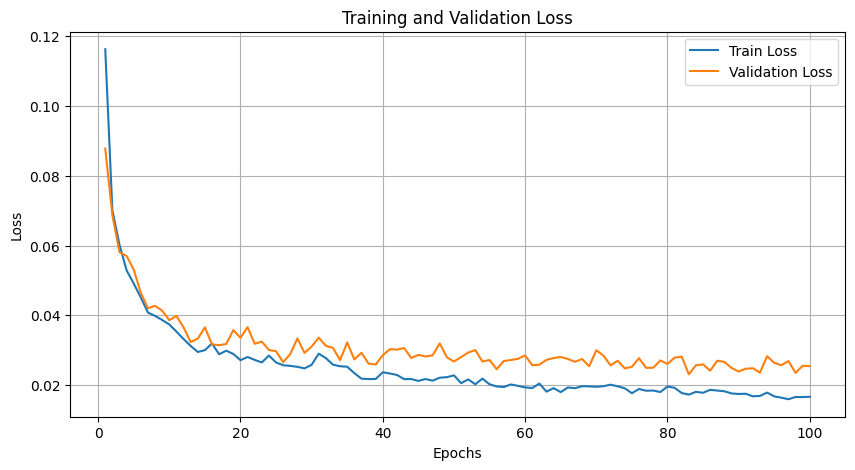

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


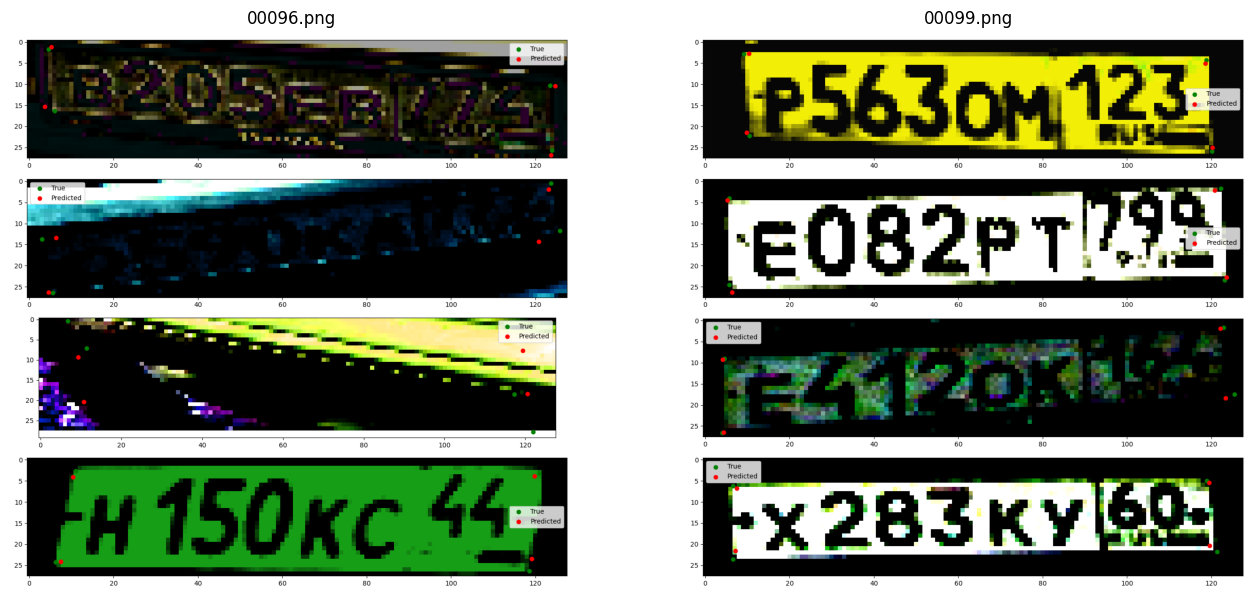

In [4]:
image_files = [name for name in os.listdir(save_path) if name.endswith('.png')][-2:]
plt.figure(figsize=(16, 8))
for i, image_file in enumerate(image_files):
    img_path = os.path.join(save_path, image_file)
    img = Image.open(img_path)
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.show()